# Policy Improvement

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/riccardoberta/machine-learning/blob/master/05-reinforcement-learning/05-policy-improvements.ipynb)

We introduce agents that improve the policy. Instead of estimating state-value function $V(s)$, we estimate action-value functions $Q(s,a)$, in order to see the value of actions without having to use an MDP. Then, after we obtain this estime, we use it to improve the policy. This is similar to what we did in the policy-iteration algorithm: we evaluate, we improve, then evaluate the improved policy, then improve on this improved policy, and so on.

$\pi_0 \overset{evaluate}{\longrightarrow }  q_{\pi_0} \overset{improve}{\longrightarrow } \pi_1 \overset{evaluate}{\longrightarrow }  q_{\pi_1} \overset{improve}{\longrightarrow } \pi_2 \overset{evaluate}{\longrightarrow } ... \overset{improve}{\longrightarrow } \pi_* \overset{evaluate}{\longrightarrow }  q_{\pi_*}$

Policy improvement is done by making the policy greedy with respect to the current value function. In this case we have an action-value function, and therefore no model is needed to construct the greedy policy. For any action-value function $q$, the corresponding
greedy policy is the one that, for each $s \in S$, deterministically chooses an action with maximal action-value:

$\begin{align}
\pi(s) = \underset{a}{\arg \max}\> q(s,a)
\end{align}$

This pattern is called **generalized policy iteration (GPI)**, and it can help us create an architecture that virtually any reinforcement learning algorithm fits under, including state-of-the-art deep reinforcement learning agents.

1. [Monte Carlo Control](#Improving-policies-after-each episode:-Monte-Carlo-control)
2. [SARSA](#)
3. [Q-learning](#)
4. [Slippery Walk Environment](#)
5. [SARSA($\lambda$)](#)
6. [Q($\lambda$)](#)
7. [Comparison](#Comparison)


## Improving policies after each episode: Monte Carlo control

Policy improvement can be done by constructing each $\pi_{k+1}$ as the greedy policy with respect to $q_{\pi_k}$. The policy improvement theorem then applies to:

$\begin{align}
q_{\pi_k}(s, \pi_{k+1}(s)) = q_{\pi_k}(s, \underset{a}{\arg \max}\> q_{\pi_k}(s,a)) 
 = \underset{a}{\max} q_{\pi_k}(s,a)) \geq q_{\pi_k}(s, \pi_k(s)) \geq v_{\pi_k}(s)
\end{align}$

this assures that each $\pi_{k+1}$ is better than (or just as good as) $\pi_k$, so the overall process converges to the optimal policy and optimal value function.


First, we need to make sure our agent estimates the action-value function $Q(s,a)$, instead of the $V(s)$ (in order to know what the best action is to take from a state). Second, we need to make sure our agent explores. The problem is that we’re no longer using the MDP for our policy-evaluation needs. When we estimate from samples, we get values for all of the state-action pairs we visited, but what if part of the best states weren’t visited? Therefore, let’s use first-visit Monte Carlo prediction for the policy-evaluation
phase and a decaying epsilon-greedy action-selection strategy for the policy-improvement phase. 

Instead of rolling out several episodes for estimating the value function of a single policy, we truncate the prediction step after a single full rollout and trajectory sample estimation, and improve the policy right after that single estimation step. We alternate a single MC-prediction step and a single decaying epsilon-greedy action-selection improvement step.

Let's implement in Python.

The decay schedule function for both alpha and epsilon is the same we used in the policy evaluation chapter:

In [175]:
import numpy as np

def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

The generate_trajectory function is slightly different. We now need to take in an action-selecting strategy, instead of a greedy policy:

In [176]:
from itertools import count

def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            
            # here is the difference: use the ‘select_action’ function to pick an action
            action = select_action(state, Q, epsilon) 
            
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, object)

Then we can write the Monte Carlo control algorithm, which is similar to the prediction. The two main differences is that we now estimate the action-value function Q, and that we need to explore (we use an decaying epsilon to control random exploration).

In [177]:
def mc_control(env, gamma=1.0,
               init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
               init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
               n_episodes=2000, max_steps=200):
    
    nS, nA = env.space_size, env.actions_size
    
    # calculate values for the discount factors in advance
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False) 
    
    # calculate alphas in advance
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    
    # calculare epsilons in advance
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    
    # setting up variables
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # here we define a exploratory policy based on an epsilon-greedy strategy
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))

    # the episode loop    
    for e in range(n_episodes):
        
        # generate a trajectory using the defined exploratory policy
        trajectory = generate_trajectory(select_action, Q, epsilons[e], env, max_steps)
        
        # keep track of the visits to state-action pairs
        visited = np.zeros((nS, nA), dtype=bool)
        
        # process the trajectory offline, after the interactions with the 
        # environment have stopped
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            
            # check for state-action pair visits
            if visited[state][action]: continue
            visited[state][action] = True
            
            # calculate the return and estimate the value function (Q this time)
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])
            V = np.max(Q, axis=1)

        # save values for post analysis
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))
    
    # At the end, we extract the state-value function and the greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

## Improving policies after each step: SARSA

One of the disadvantages of Monte Carlo methods is that they’re offline methods in an episode-to-episode sense. What that means is that we must wait until we reach a terminal state before we can make any improvements to our value function estimates. However, it’s straightforward to use temporal-difference prediction for the policy-evaluation phase, instead of Monte Carlo prediction. By replacing MC with TD prediction, we now have a different algorithm, the well-known SARSA agent.

$\begin{align}
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)] 
\end{align}$

We can implement it in Python:

In [178]:
def sarsa(env, gamma=1.0,
          init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
          init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9, 
          n_episodes=2000):
    
    nS, nA = env.space_size, env.actions_size
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    
    for e in range(n_episodes):
        
        # we start episode by resetting the environment and the done flag
        state, done = env.reset(), False
        
        # select the action (perhaps exploratory) for the initial state
        action = select_action(state, Q, epsilons[e])
        
        # repeat until we hit a terminal state
        while not done:
            
            # step the environment and get the experience
            next_state, reward, done, _ = env.step(action)
            
            # obtain the action for the next step
            next_action = select_action(next_state, Q, epsilons[e])
            
            # calculate the td_target using that next state-action pair
            # we do the little trick for terminal states of multiplying by 
            # not done, which zeros out the future on terminal
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            
            # calculate the td_error                                   
            td_error = td_target - Q[state][action]
            
            # update the Q-function
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            V = np.max(Q, axis=1)
            
            # update state and action for the next step
            state, action = next_state, next_action
            
        # save the Q-function and greedy policy for analysis    
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    # calculate the V-function and its greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

Greedy in the limit with infinite exploration (GLIE) is a set of requirements that on-policy RL algorithms, such as Monte Carlo control and SARSA, must meet to guarantee convergence to the optimal policy. The requirements are as follows: (a) **all state-action pairs must be explored infinitely often** and (b) **the policy must converge on a greedy polic**. In practice this means that an the epsilon-greedy exploration strategy must slowly decay epsilon towards zero. If it goes down too quickly, the first condition may not be met; if it decays too slowly, well, it takes longer to converge.

## Decoupling behavior from learning: Q-Learning

The SARSA algorithm is a sort of "learning on the job": the agent learns about the same policy it uses for generating experience. This type of learning is called **on-policy learning**. It is excellent, we learn from our own mistakes. But we learn from our own current mistakes only. What if we want to learn from our own previous mistakes? What if we want to learn from the mistakes of others? **Off-policy learning**, on the other hand, is sort of "learning from others": the agent learns about a policy that’s different from the one used to generate experiences. In off-policy learning, there are two policies: a behavior policy, used to generate experiences, to interact with the environment, and a target policy, which is the policy we’re learning about. The most used off-policy algorithm is called **Q-Learning**.

The only difference between SARSA and Q-learning is the action used in the target. SARSA uses the action taken in the next state to calculate the target. Q-learning uses the action with the maximum estimated value in the next state, despite the action taken:

$\begin{align}
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma  \underset{a}{\text{ max }} Q(S_{t+1}, a) - Q(S_t, A_t)] 
\end{align}$

We can implement this in Python:

In [179]:
def q_learning(env, gamma=1.0,
               init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
               init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
               n_episodes=2000):
    nS, nA = env.space_size, env.actions_size
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    
    for e in range(n_episodes):
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            
            # calculate the target: here is Q-learning
            td_target = reward + gamma * Q[next_state].max() * (not done)
            
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            V = np.max(Q, axis=1)
            state = next_state

        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

Notice that for off-policy RL algorithms, such as Q-learning, the only requirement that holds of the two for convergence is the first one. The second one is no longer a requirement because in off-policy learning, the policy learned is different than the policy we’re sampling actions from. 

Q-learning often overestimates the value function: on every step, we take the maximum over the estimates of the action-value function of the next state, but what we need is the actual value of the maximum action-value function of the next state. In other words, we’re using the maximum over merely estimates as an estimate of the maximum. But these estimates are often biased. The use of a maximum of biased estimates as the estimate of the maximum value is a problem known as **maximization bias**. It’s simple: Iimagine an action-value function whose actual values are all zeros, but the estimates have bias (0.11, 0.65, –0.44, –0.26, and so on). We know the actual maximum is zero, but the maximum over the estimates is 0.65. One way of dealing with this is a technique called **double Q-learning** [Hasselt, Hado. "Double Q-learning." Advances in neural information processing systems NIPS (2010)](https://proceedings.neurips.cc/paper/2010/hash/091d584fced301b442654dd8c23b3fc9-Abstract.html). The idea is to maintain two Q-value functions $Q_A$ and $Q_B$, each one gets update from the other for the next state. The update consists of finding the action $a^*$ that maximises $Q_A$ in the next state, then use $a^*$ to get the value of $Q_B(s', a^*)$ in order to update $Q_A(s, a)$. We can think of this similar to cross-validation: one Q-function estimates will help us validate the other Q-function estimates. The issue, though, is now we’re splitting the experience between two separate functions and this somewhat slows down training.

In [180]:
def double_q_learning(env,gamma=1.0,
                      init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
                      init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
                      n_episodes=2000):
    
    nS, nA = env.space_size, env.actions_size
    pi_track = []
    
    # two state-value functions Q1 and Q2. 
    Q1 = np.zeros((nS, nA), dtype=np.float64)
    Q2 = np.zeros((nS, nA), dtype=np.float64)
    
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    
    for e in range(n_episodes):
        state, done = env.reset(), False
        while not done:
            
            # use the mean of our two Q-functions to select action 
            action = select_action(state, (Q1 + Q2)/2, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            
            # flip a coin to determine an update to Q1 or Q2
            if np.random.randint(2):
                # use the action Q1 thinks is best...
                argmax_Q1 = np.argmax(Q1[next_state])
                # ...but get the value from Q2 to calculate the target
                td_target = reward + gamma * Q2[next_state][argmax_Q1] * (not done)
                td_error = td_target - Q1[state][action]
                # update Q1
                Q1[state][action] = Q1[state][action] + alphas[e] * td_error
            else:
                # use the action Q2 thinks is best...
                argmax_Q2 = np.argmax(Q2[next_state])
                # ...but get the value from Q1 to calculate the target
                td_target = reward + gamma * Q1[next_state][argmax_Q2] * (not done)
                td_error = td_target - Q2[state][action]
                # update Q2
                Q2[state][action] = Q2[state][action] + alphas[e] * td_error
            state = next_state
        
        Q = (Q1 + Q2)/2.
        V = np.max(Q, axis=1)
        Q_track[e] = Q
        V_track[e] = V
        
        # notice the policy is the argmax of the mean of Q1 and Q2
        pi_track.append(np.argmax((Q1 + Q2)/2, axis=1))
    
    # the final Q is the mean
    Q = (Q1 + Q2)/2.
    V = np.max(Q, axis=1)    
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track

## Slippery Walk Seven environment

We use an environment called **slippery walk seven (SWS)**. This environment is a walk, a single-row grid-world environment, with seven non-terminal states. The particular thing of this environment is that it’s a slippery walk; action effects are stochastic. If the agent chooses to go left, there is a chance it does, but there is also a chance that it goes right, or that it stays in place.

<img src="./images/slippery-walk.png" width="600">

This environment is noisy, but the actions the agent selects make a difference in its performance.

In [181]:
import random
        
class SlipperyWalk:
    def __init__(self):
        self.reset()

    def reset(self):
        self.space_size = 9
        self.actions_size = 2
        self._state = np.random.choice([1,2,3,4,5,6,7])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        
        if(action==0): direction = -1
        if(action==1): direction = 1
        
        direction_list = [direction, -direction, 0]
        true_direction = random.choices(direction_list, weights=(50, 17, 33), k=1)
        self._state += true_direction[0]
        
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 7: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [182]:
env = SlipperyWalk()

The optimal state value function can be caluculated using the MDP and appliyng the Dynimic Programmaing:

In [183]:
optimal_V = [0., 0.5637, 0.763, 0.8449, 0.8892, 0.922, 0.9515, 0.9806, 0.]  

Let’s put it all together and test all the algorithms we just learned about in the Slippery Walk Seven environment. Ww use the same hyperparameters in all algorithms, the same gamma, alpha, epsilon, and respective decaying schedules. 

This first one is first-visit Monte Carlo control (on-policy, no bootstrapping)

In [184]:
Q_mc, V_mc, pi_mc, Q_track_mc, V_track_mc, pi_track_mc = mc_control(env)

In [185]:
print(V_mc)

[0.         0.62535167 0.88050821 0.930206   0.97756343 0.99925
 0.99988165 0.99999876 0.        ]


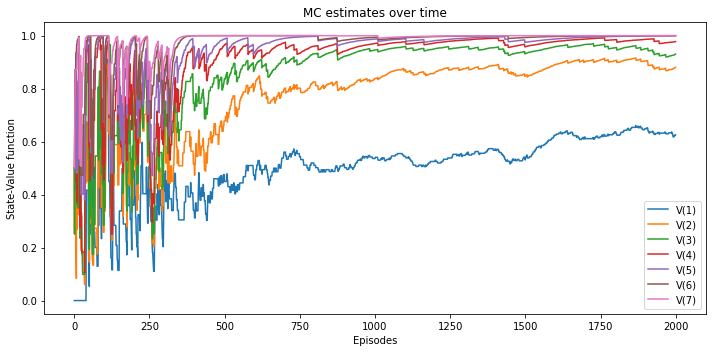

In [188]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)', 'V(6)', 'V(7)']

plt.figure(figsize=(10,5))
plt.plot(V_track_mc[:,1:8])
plt.title('MC estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

Notice how the estimates of MC have high variance.

Now SARSA (on-policy, bootstrapping):

In [189]:
Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, V_track_sarsa, pi_track_sarsa = sarsa(env)

In [190]:
print(V_sarsa)

[0.         0.5397064  0.79474997 0.91048828 0.95573154 0.9779803
 0.99209906 0.99757238 0.        ]


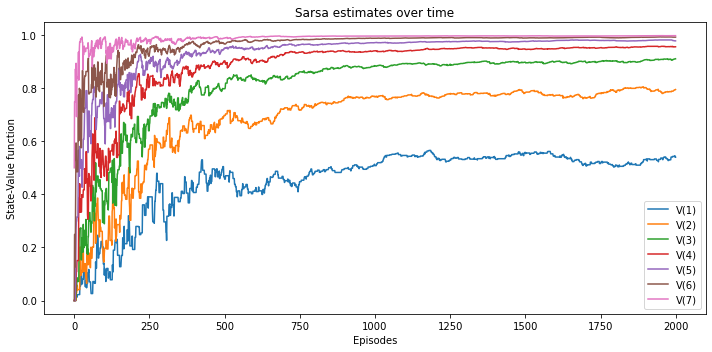

In [191]:
plt.figure(figsize=(10,5))
plt.plot(V_track_sarsa[:,1:8])
plt.title('Sarsa estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

We can see how SARSA has less variance than MC, yet it takes pretty much the same amount of time to get to the optimal values.

The Q-learning (off-policy, bootstrapping):

In [192]:
Q_q, V_q, pi_q, Q_track_q, V_track_q, pi_track_q = q_learning(env)

In [193]:
print(V_q)

[0.         0.67293052 0.89572332 0.96660657 0.98850973 0.99539577
 0.99864671 0.99961187 0.        ]


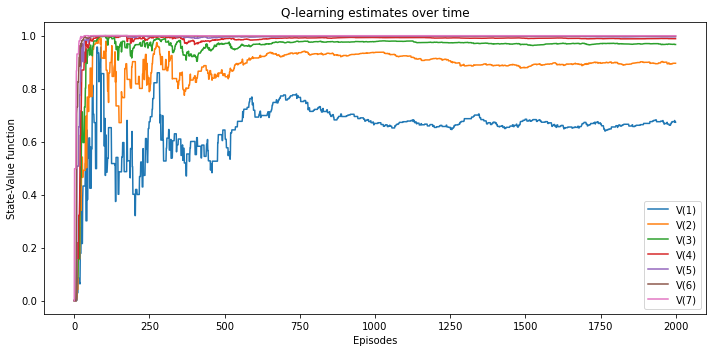

In [194]:
plt.figure(figsize=(10,5))
plt.plot(V_track_q[:,1:8])
plt.title('Q-learning estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

See how much faster the estimates track the true values. But, also, notice how the estimates are often higher and jump around somewhat aggressively

Finally, the Double Q-learning: 

In [195]:
Q_dq, V_dq, pi_dq, Q_track_dq, V_track_dq, pi_track_dq = double_q_learning(env)

In [196]:
print(V_dq)

[0.         0.63081529 0.8782031  0.95517806 0.9842668  0.99468499
 0.99840452 0.99956132 0.        ]


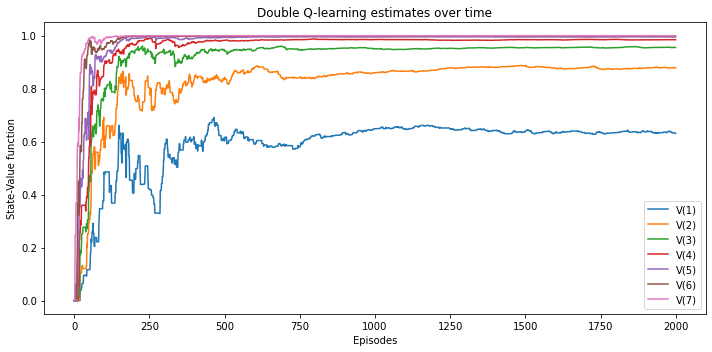

In [197]:
plt.figure(figsize=(10,5))
plt.plot(V_track_dq[:,1:8])
plt.title('Double Q-learning estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

It is slightly slower than Q-learning to get the estimates to track the optimal state-value function, but it does so in a much more stable manner. There’s still a bit of over-estimation, but it’s controlled.

## Using multi-step estimates: SARSA($\lambda$)

SARSA($\lambda$) is a straightforward improvement to the original SARSA agent. The main difference is that instead of using a one-step bootstrapping target, we use the $\lambda$-return. For adapting the eligibility trace to solving the control problem, the only necessary change is that instead of using an eligibility vector for tracking visited states, we use an eligibility matrix for tracking visited state-action pairs.


When our agent tries a state-action pair, the trace for this pair is incremented by one. Now, imagine there’s a loop in the environment, and the agent tries the same state-action pair several times. Should we make this state-action pair "more" responsible for rewards obtained in the future, or should we make it just responsible? The type of eligibility trace that we used is called the **accumulating trace** and allows trace values higher than one. However, in reality, there are multiple ways of tracing state or state-action pairs responsible for a reward. For example, the **replacing trace** mechanism consists of clipping eligibility traces to a maximum value of one. The following figure shows the two strategy applied to the SWS environment:

<img src="./images/replacing-trace.png" width="800">

Accumulating traces can "exaggerate" when confronted with frequency while replacing traces moderate the blame assigned to frequent events. This moderation can help the more recent, but rare events surface and be taken into account.

We can implement SARSA($\lambda$) in Python:

In [198]:
def sarsa_lambda(env, gamma=1.0,
                 init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
                 init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
                 lambda_=0.5, replacing_traces=True, n_episodes=2000):
    nS, nA = env.space_size, env.actions_size
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # eligibility traces to keep track of states 
    # eligible for updates
    E = np.zeros((nS, nA), dtype=np.float64)
    
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon,  epsilon_decay_ratio, n_episodes)
    
    for e in range(n_episodes):
        # every new episode, set the eligibility of every state to zero
        E.fill(0)

        # select the action of the initial state
        state, done = env.reset(), False
        action = select_action(state, Q, epsilons[e])
        
        # interaction loop
        while not done:
            
            # step the environment and get the experience
            next_state, reward, done, _ = env.step(action)
            
            # obtain the action for the next step
            next_action = select_action(next_state, Q, epsilons[e])

            # calculate the td_target using that next state-action pair
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            
            # calculate the td_error 
            td_error = td_target - Q[state][action]
            
            # increment the state-action pair trace, 
            # and clip it to 1 if it’s a replacing trace
            if replacing_traces: E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: E.clip(0, 1, out=E)
            
            # apply the TD error to all eligible state-action pairs at once
            # even though we’re using the entire Q-table, E will be mostly 0, 
            # and greater than zero for eligible pairs
            Q = Q + alphas[e] * td_error * E
            E = gamma * lambda_ * E
            V = np.max(Q, axis=1)
            
            # update state and action for the next step
            state, action = next_state, next_action

        # save the Q-function and greedy policy for analysis    
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    # calculate the V-function and its greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

We can apply the algorithm to the same SWS environment:

In [199]:
Q_sarsa_lambda, V_sarsa_lambda, pi_sarsa_lambda, Q_track_sarsa_lambda, V_track_sarsa_lambda, pi_track_sarsa_lambda = sarsa_lambda(env)

In [200]:
print(V_sarsa_lambda)

[0.         0.60964263 0.82324306 0.92654933 0.97006107 0.9872162
 0.99527011 0.99895774 0.        ]


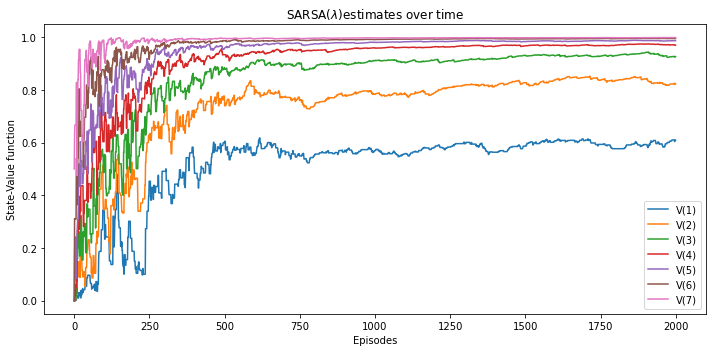

In [201]:
plt.figure(figsize=(10,5))
plt.plot(V_track_sarsa_lambda[:,1:8])
plt.title('SARSA($\lambda$)estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

## Using multi-step estimates and decoupling behaviour from learning: Q($\lambda$)

There’s an off-policy control version of the $\lambda$ algorithms. Q($\lambda$) is an extension of Q-learning that uses the $\lambda$-return for policy-evaluation requirements of the generalized policy-iteration pattern. Remember, the only change we’re doing here is replacing the TD target for off-policy control (the one that uses the max over the action in the next state) with a $\lambda$-return for off-policy control.

In [205]:
def q_lambda(env, gamma=1.0,
             init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
             init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
             lambda_=0.5, replacing_traces=True, n_episodes=2000):
    
    nS, nA = env.space_size, env.actions_size
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
        
    E = np.zeros((nS, nA), dtype=np.float64)
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    
    for e in range(n_episodes):
        E.fill(0)
        
        state, done = env.reset(), False
        
        # notice: we are preselecting the action as in SARSA, 
        # but we didn’t do that in Q-learning. 
        # this is because we need to check whether our next action is greedy!
        action = select_action(state, Q, epsilons[e])
        
        while not done:
            
            next_state, reward, done, _ = env.step(action)
            
            # select the next_action SARSA-style
            next_action = select_action(next_state, Q, epsilons[e])
            
            # use it to verify that the action on the next step 
            # will still come from the greedy policy
            next_action_is_greedy = Q[next_state][next_action] == Q[next_state].max()

            # still calculate the TD target as in regular Q-learning, using the max.
            td_target = reward + gamma * Q[next_state].max() * (not done)
            
            # and use the TD target to calculate the TD error.
            td_error = td_target - Q[state][action]
            
            if replacing_traces: E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: E.clip(0, 1, out=E)
            
            # as before, we multiply the entire eligibility trace matrix 
            # by the error and the learning rate corresponding to episode e, 
            Q = Q + alphas[e] * td_error * E
            V = np.max(Q, axis=1)
            
            # notice: if the action we’ll take on the next state 
            # (which we already selected) is a greedy action, then we decay 
            # the eligibility matrix as usual, otherwise, we must reset 
            # the eligibility matrix to zero because we’ll no longer be learning 
            # about the greedy policy.
            if next_action_is_greedy:
                E = gamma * lambda_ * E
            else:
                E.fill(0)

            state, action = next_state, next_action

        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track

We can apply the algorithm to the same SWS environment:

In [207]:
Q_q_lambda, V_q_lambda, pi_q_lambda, Q_track_q_lambda, V_track_q_lambda, pi_track_q_lambda = q_lambda(env)

In [208]:
print(V_sarsa_lambda)

[0.         0.60964263 0.82324306 0.92654933 0.97006107 0.9872162
 0.99527011 0.99895774 0.        ]


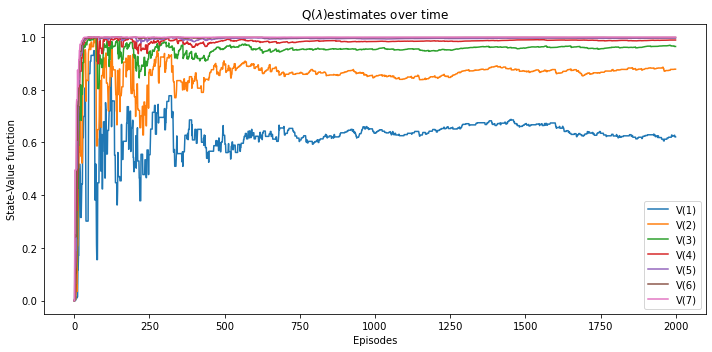

In [209]:
plt.figure(figsize=(10,5))
plt.plot(V_track_q_lambda[:,1:8])
plt.title('Q($\lambda$)estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

## Comparison

In  the next plot, we’re looking at the state-value function estimation error. This is the Mean absolute error across all estimates from their respective optimal. Take a look at how quickly Q-learning drops near zero, but also how double Q-learning gets to the lowest error first. 

In [202]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

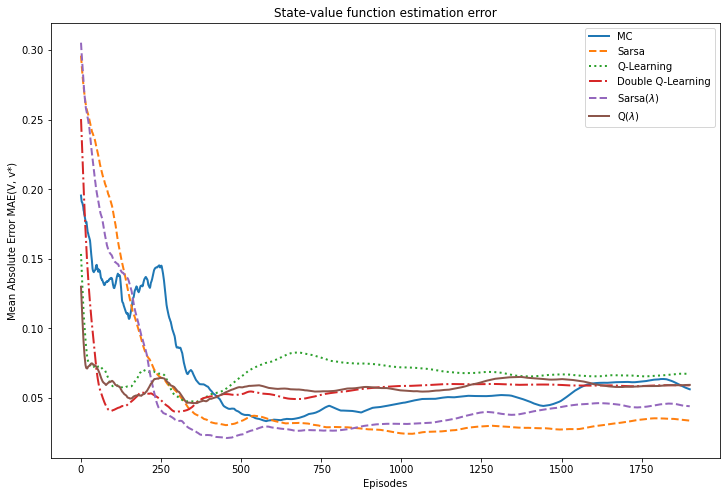

In [210]:
plt.figure(figsize=(12,8))
plt.plot(moving_average(np.mean(np.abs(V_track_mc - optimal_V), axis=1)), 
         '-', linewidth=2, label='MC')
plt.plot(moving_average(np.mean(np.abs(V_track_sarsa - optimal_V), axis=1)), 
         '--', linewidth=2, label='Sarsa')
plt.plot(moving_average(np.mean(np.abs(V_track_q - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(V_track_dq - optimal_V), axis=1)), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.mean(np.abs(V_track_sarsa_lambda - optimal_V), axis=1)), 
         '--', linewidth=2, label='Sarsa($\lambda$)')
plt.plot(moving_average(np.mean(np.abs(V_track_q_lambda - optimal_V), axis=1)), 
         '-', linewidth=2, label='Q($\lambda$)')
plt.legend(loc=1, ncol=1)

plt.title('State-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')

plt.show()